In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

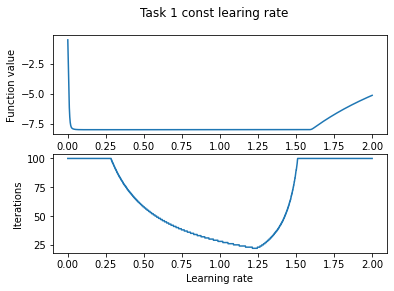

In [9]:
def gradient_descent(gradient_func, step_func, start_point, iterations, eps):
    '''
    Метод градиентного спуска
    :param gradient_func: функция градиента
    :param step_func: функция изменения шага
    :param start_point: начальное приближение
    :param eps: точность расчета
    '''
    current_point = start_point
    for it in range(iterations):
        vector = gradient_func(current_point)
        step = step_func(it, current_point, vector)
        next_point = current_point - step * vector
        distance = np.linalg.norm(current_point - next_point)

        if distance < eps:
            return current_point, it

        current_point = next_point

    return current_point, iterations

def const_learning_rate(value):
    '''
    Постоянный шаг для метода градиентного спуска
    '''
    return lambda i, _0, _1: value

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
gradient = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

learning_rate_iterations = np.arange(0.001, 2, 0.001)
func_values = []
iterations_count = []

for learning_rate in learning_rate_iterations:
    (xs, it) = gradient_descent(
        gradient_func=gradient, 
        step_func=const_learning_rate(learning_rate),
        start_point=np.array([1.0, 2.0]), 
        iterations=100,
        eps=1e-5
    )
    func_values.append(func(xs))
    iterations_count.append(it)


fig, axs = plt.subplots(2)
fig.suptitle('Task 1 const learing rate')

axs[0].set_xlabel("Learning rate")
axs[0].set_ylabel("Function value")
axs[0].plot(learning_rate_iterations, func_values)

axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Iterations")
axs[1].plot(learning_rate_iterations, iterations_count)

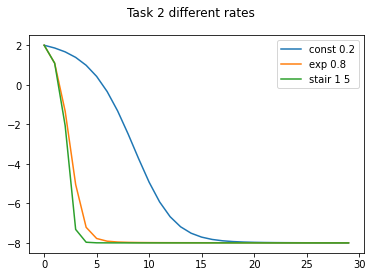

In [10]:
def exp_learning_rate(value):
    return lambda i, _0, _1: value ** i

def stair_learning_rate(coeff, size):
    return lambda i, _0, _1: coeff / (1 + i // size)

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
gradient = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

start_point = np.array([-10.0, 20.0])
learning_rate_iterations = np.arange(30)

plots = []
for learning_rate, label in [(const_learning_rate(0.2), "const 0.2"),
                            (exp_learning_rate(0.8), "exp 0.8"),
                            (stair_learning_rate(1, 5), "stair 1 5")]:
    plots.append(
      plt.plot(
          learning_rate_iterations,
          np.array(list(map(
              lambda it: func(gradient_descent(gradient, learning_rate, np.copy(start_point), it, 1e-5)[0]),
              learning_rate_iterations
          ))),
          label=label
      )[0]
    )

plt.suptitle('Task 2 different rates')
plt.legend(handles=plots)

In [23]:
def golden_section_search(func, l, r, eps):
    '''
    Метод золотого сечения
    :param func: целевая функция
    :param l: левая граница отрезка
    :param r: правая граница отрезка
    :param eps: точность расчета
    '''
    phi = (1 + math.sqrt(5)) / 2
    current_l = l
    current_r = r
    while current_r - current_l > eps:
        fraction = (current_r - current_l) / phi
        candidate_l = current_r - fraction
        candidate_r = current_l + fraction
        if func(candidate_l) > func(candidate_r):
            current_l = candidate_l
        else:
            current_r = candidate_r
    return (current_l + current_r) / 2


func = lambda x: (x + 5) ** 4  # (x+5)^4

l = -100
r = 100
eps = 0.2

x = golden_section_search(func, l, r, eps)

print(x)
func(x)

-5.02499874064149


3.9054629604039195e-07

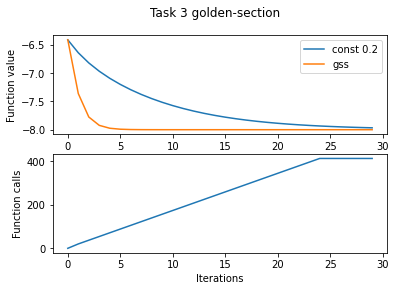

In [22]:
def gss_based_step_func(func):
    '''
    Вспомогательная функция, которая строит функцию изменения шага на основе метода золотого сечения.
    :param func: целевая функция
    '''
    def step_func(it, point, vector):
        def point_value(alpha):
            return func(point - alpha * vector)
        alpha = 1.0
        origin_value = point_value(0)
        alpha_value = point_value(alpha)
        if origin_value > alpha_value:
            for i in range(10):
                alpha *= 2
                next_alpha_value = point_value(alpha)
                if next_alpha_value > alpha_value:
                    break
                alpha_value = next_alpha_value
        return golden_section_search(point_value, 0.0, alpha, 0.1)
    return step_func

func = lambda xs: 5 * math.sin(xs[0] / 2) - 3 * math.cos(xs[1] / 3)  # 5sin(x/2)-3cos(y/3)
gradient = lambda xs: np.array([5 / 2 * math.cos(xs[0] / 2), math.sin(xs[1] / 3)])  # [5/2 * cos(x/2), sin(y/3)]

start_point = np.array([10.0, -3.0])
learning_rate_iterations = np.arange(30)
eps = 1e-5

fig, axs = plt.subplots(2)
plots = []
for learning_rate, label in [(const_learning_rate(0.2), "const 0.2"),
                            (gss_based_step_func(func), "gss")]:
    plots.append(
      axs[0].plot(
          learning_rate_iterations,
          np.array(list(map(
              lambda it: func(gradient_descent(gradient, learning_rate, np.copy(start_point), it, eps)[0]),
              learning_rate_iterations
          ))),
          label=label
      )[0]
    )

def count_func_calls(it):
    '''
    Функция, отвечающая за подсчет количества вызовов целевой функции в зависимости от числа итерации спуска
    :param it: количество итераций
    '''
    def counting_calls_func(xs):
        global number_of_calls
        counting_calls_func.number_of_calls += 1
        return func(xs)
    counting_calls_func.number_of_calls = 0
    gradient_descent(gradient, gss_based_step_func(counting_calls_func), np.copy(start_point), it, eps)[0]
    return counting_calls_func.number_of_calls

iterations_count = list(map(count_func_calls, learning_rate_iterations))

fig.suptitle('Task 3 golden-section')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Function value')
axs[0].legend(handles=plots)

axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Function calls')
axs[1].plot(learning_rate_iterations, iterations_count)

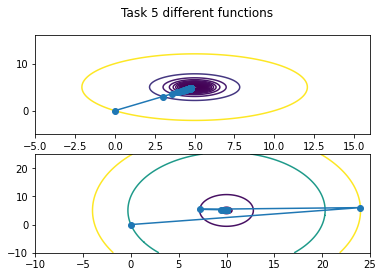

In [21]:
fig, axs = plt.subplots(2)

def draw(func, gradient, ax, l, r):
    t = np.linspace(l, r, 1000)
    X, Y = np.meshgrid(t, t)
    start_point = np.array([0, 0])
    
    learning_rate_iterations = np.arange(50)
    points = list(map(
        lambda it: gradient_descent(gradient, stair_learning_rate(0.3, 1), start_point, it, 1e-5)[0],
        learning_rate_iterations
    ))
    
    ax.plot(list(map(lambda p: p[0], points)), list(map(lambda p: p[1], points)), 'o-')
    ax.contour(X, Y, func([X, Y]), levels=sorted([func(p) for p in points]))

fig.suptitle('Task 5 different functions')

func = lambda xs: (xs[0] - 5) ** 2 + (xs[1] - 5) ** 2  # (x-5)^2 + (y-5)^2
gradient = lambda xs: np.array([2 * (xs[0] - 5), 2 * (xs[1] - 5)])  # [2(x-5), 2(y-5)]
draw(func, gradient, axs[0], -5, 16)

func = lambda xs: 4 * (xs[0] - 10) ** 2 + (xs[1] - 5) ** 2  # 4(x-10)^2 + 2(y-5)^2
gradient = lambda xs: np.array([8 * (xs[0] - 10), 4 * (xs[1] - 5)])  # [8(x-10), 4(y-5)]
draw(func, gradient, axs[1], -10, 25)
